# Importing libraries

In [15]:
import pandas as pd
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from itertools import combinations 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import tensorflow as tf
import csv
from keras.layers import Dense, Dropout, LSTM, Bidirectional
import matplotlib.pyplot as plt

# Data Exploration

In [3]:
Data = pd.read_csv("/home/ege/Desktop/kaggle/NLP/archive/training.1600000.processed.noemoticon.csv" , encoding='latin-1')

In [4]:
Data.shape

(1599999, 6)

In [5]:
Train_Data = Data.iloc[5:-5]
Val_part1 = Data.iloc[:5]
Val_part2 = Data.iloc[-5:]
Val_data = pd.concat([Val_part1 , Val_part2] , axis = 0)

This dataset is huge. We will split this data set. 900000 tweets are enough for this project.



In [6]:
Train_Data = Data.iloc[np.random.choice(np.arange(len(Data)), 900000, False)]

In [9]:
Train_Data.head()

,sentiment,Id,date,query,username,tweets
1005391,4,1880505941,Fri May 22 01:29:10 PDT 2009,NO_QUERY,phatrisha,?currently playing OL games @ y8.com
534036,0,2197388970,Tue Jun 16 13:43:13 PDT 2009,NO_QUERY,AwesomeBlossom,had permanent crown put on this morning...what...
1216996,4,1989693999,Mon Jun 01 02:28:25 PDT 2009,NO_QUERY,melattree,I am powering through work and showing Monday ...
852619,4,1573004668,Mon Apr 20 23:20:48 PDT 2009,NO_QUERY,JacandJill,Got back from The Cutting Room
1327435,4,2015386695,Wed Jun 03 04:31:36 PDT 2009,NO_QUERY,BritFan85,I remembrd my gym bag. Thank g0d. I dnt hav 2 ...


Adding columns names

In [10]:
Train_Data.columns = ["sentiment", "Id", "date", "query", "username", "tweets"]

In [11]:
Train_Data.head()

,sentiment,Id,date,query,username,tweets
1005391,4,1880505941,Fri May 22 01:29:10 PDT 2009,NO_QUERY,phatrisha,?currently playing OL games @ y8.com
534036,0,2197388970,Tue Jun 16 13:43:13 PDT 2009,NO_QUERY,AwesomeBlossom,had permanent crown put on this morning...what...
1216996,4,1989693999,Mon Jun 01 02:28:25 PDT 2009,NO_QUERY,melattree,I am powering through work and showing Monday ...
852619,4,1573004668,Mon Apr 20 23:20:48 PDT 2009,NO_QUERY,JacandJill,Got back from The Cutting Room
1327435,4,2015386695,Wed Jun 03 04:31:36 PDT 2009,NO_QUERY,BritFan85,I remembrd my gym bag. Thank g0d. I dnt hav 2 ...


In [12]:
df_tweets = Train_Data[['tweets']]
df_sentiment = Train_Data[['sentiment']]
df_sentiment['sentiment'] = df_sentiment['sentiment'].replace(4,1)

<ipython-input-12-896fdaaed720>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment['sentiment'] = df_sentiment['sentiment'].replace(4,1)


In [13]:
Val_data.columns = ["sentiment", "Id", "date", "query", "username", "tweets"] 
Val_data['sentiment'] = Val_data['sentiment'].replace(4 ,1)
Val_data_sentiment = Val_data[['tweets']]
Val_data_labels = Val_data[['sentiment']]

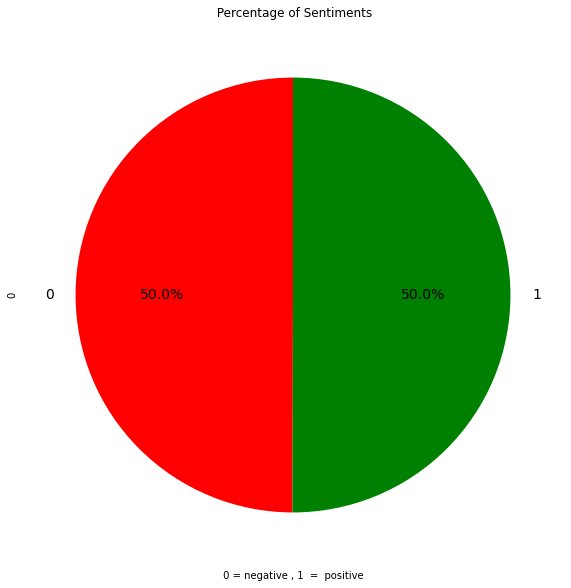

In [16]:
sentiments = df_sentiment.groupby(['sentiment']).size().reset_index()
sentiments.plot(kind='pie' ,y = 0, autopct='%1.1f%%',  title = " Percentage of Sentiments",
startangle=90, shadow=False, labels=  sentiments['sentiment'], legend = False, fontsize=14, figsize=(10, 10) , colors = 'rg')
plt.xlabel(' 0 = negative , 1  =  positive ')
plt.show()

# Data Preprocessing

In [59]:
contractions = pd.read_csv("/home/ege/Desktop/kaggle/NLP/archive/contractions.csv")
contractions.head()

,Contraction,Meaning
0,'aight,alright
1,ain't,is not
2,amn't,am not
3,aren't,are not
4,can't,cannot


In [60]:
def lower(data):
    columns = data.columns
    for col in columns:
        data[col] = data[col].apply(str)
        data[col] = data[col].str.lower()
    return data    

In [61]:
contractions = lower(contractions)
df_tweets = lower(df_tweets)
Val_data = lower(Val_data)


<ipython-input-60-b0cb6929ce64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(str)
<ipython-input-60-b0cb6929ce64>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].str.lower()


In [62]:
def df_to_dict(data):
    dictionary = dict()
    col_names = data.columns
    for _ in range(data.shape[0]):
        dictionary[data[col_names[0]].iloc[_]] = data[col_names[1]].iloc[_]
    return dictionary   
        

In [63]:
contractions_dict    = df_to_dict(contractions)

In [64]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

In [65]:
def preprocess_data(tweet):

    #tweet = lower(tweet)

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet )
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [66]:
df_tweets['processed_tweets'] = df_tweets['tweets'].apply(preprocess_data)
Val_data_sentiment['processed_tweets'] = Val_data_sentiment['tweets'].apply(preprocess_data)

<ipython-input-66-01506bbefeac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets['processed_tweets'] = df_tweets['tweets'].apply(preprocess_data)
<ipython-input-66-01506bbefeac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Val_data_sentiment['processed_tweets'] = Val_data_sentiment['tweets'].apply(preprocess_data)


In [67]:
df_tweets.head()

,tweets,processed_tweets
1232659,@chrisochs hope you find this to be fun! do yo...,<user> hope you find this to be fun do you ne...
1280687,done running time to hut the weights,done running time to hut the weights
870256,watching the chart show whilst dad is jumpin o...,watching the chart show whilst dad is jumpin o...
8045,@paranoidartemus i work as a graphic designer ...,<user> i work as a graphic designer for a smal...
1280993,http://twitpic.com/6ge89 - my happy twitter th...,<url> my happy twitter throw back moment tha...


In [69]:
XTrain = df_tweets['processed_tweets']
YTrain = df_sentiment
X_train, X_test, y_train, y_test = train_test_split(XTrain, YTrain,test_size = 0.2, random_state = 42)

In [70]:
W2vec_train = list(map(lambda x: x.split(), X_train))

In [71]:
embedding_dimensions = 100
word2vec_model = Word2Vec(W2vec_train,
                 size=embedding_dimensions,
                 workers=8,
                 min_count=5)
print("Vocabulary Length:", len(word2vec_model.wv.vocab))

Vocabulary Length: 33927


In [73]:
word2vec_model.most_similar("bad")

<ipython-input-73-4dbf9e918252>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  word2vec_model.most_similar("bad")


[('horrible', 0.7037376165390015),
 ('baad', 0.6696481108665466),
 ('shitty', 0.6587868332862854),
 ('terrible', 0.6543588638305664),
 ('good', 0.6338827610015869),
 ('crappy', 0.6260131597518921),
 ('badd', 0.5632617473602295),
 ('weak', 0.5632414221763611),
 ('awful', 0.550317645072937),
 ('sad', 0.5468815565109253)]

In [72]:
word2vec_model.most_similar("good")

<ipython-input-72-344f146771d5>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  word2vec_model.most_similar("good")


[('great', 0.7569676041603088),
 ('rough', 0.695873498916626),
 ('tough', 0.6812916994094849),
 ('nice', 0.666936993598938),
 ('fab', 0.6364641189575195),
 ('bad', 0.6338827610015869),
 ('fantastic', 0.6302617192268372),
 ('gud', 0.6173033714294434),
 ('terrible', 0.6053646802902222),
 ('horrible', 0.5889730453491211)]

In [88]:
def prepare_texts(train,test,val , oov, num_words , max_lenght ,padding_type , trunc_type):
    
    tokenizer = Tokenizer(num_words= num_words , oov_token= oov )
    tokenizer.fit_on_texts(train)
    word_index = tokenizer.word_index
    
   
    training_sequences = tokenizer.texts_to_sequences(train)
    testing_sequences = tokenizer.texts_to_sequences(test)
    validation_sequences = tokenizer.texts_to_sequences(val)
    # pad sequences 
    training_padded = pad_sequences(training_sequences , maxlen= max_length , padding=padding_type, truncating=trunc_type)
    testing_padded = pad_sequences(testing_sequences , maxlen=max_length, padding=padding_type, truncating=trunc_type)
    validation_padded = pad_sequences(validation_sequences , maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    return training_padded , testing_padded , validation_padded, word_index

In [89]:
oov_tok = "<oov>"
num_words = len(word2vec_model.wv.vocab)
max_length = max([ len(x) for x in df_tweets['processed_tweets'].tolist()])
trunc_type='post'
padding_type='post'
embedding_dim = 100


In [90]:
training_padded,testing_padded , validation_padded ,word_index = prepare_texts(X_train , X_test , 
                                                           Val_data_sentiment['tweets'], oov_tok,num_words ,
                                                           max_length , padding_type,
                                                           trunc_type)

# Global Vectors for Word Representation

In [77]:
vocab_size  =  len(word_index)
embeddings_index = {}
with open('/home/ege/Desktop/kaggle/NLP/archive/glove.twitter.27B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

# ML Model 

In [78]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [79]:
with tf.device('/GPU:0'): 
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length,  weights=[embeddings_matrix], trainable=False),    
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(training_padded,  y_train, epochs=10, validation_data=(testing_padded, y_test), verbose=1)

print("Training Complete")    


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 368, 100)          16789000  
_________________________________________________________________
dropout (Dropout)            (None, 368, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 364, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 91, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

# Graphs

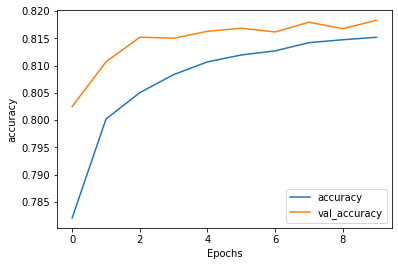

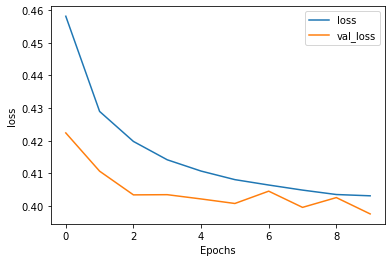

In [80]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [81]:
!mkdir -p saved_model
model.save('saved_model/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


# Predictions of validation dataset

In [91]:
predictions = model.predict(validation_padded)

In [94]:
predictions_list = []
for pred in predictions:
    if pred > 0.5:
        predictions_list.append(1)
    else:
        predictions_list.append(0)
        
        

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [99]:
cm = confusion_matrix(predictions_list,Val_data_labels )

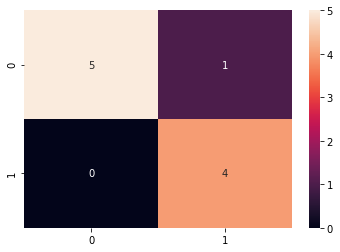

In [107]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

In [108]:
import json

In [110]:
with open('/home/ege/Desktop/kaggle/NLP/word_index.json', 'w') as fp:
    json.dump(word_index, fp)
